<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
import warnings
warnings.filterwarnings("ignore")
!pip install wandb -qq
import wandb
#from wandb.keras import WandbCallback

In [ ]:
wandb.login()

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(project="Assignment_1", name="Question_1")

##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

In [ ]:
#Load the fashion MNIST data 
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

#Splitting to get 10% data as validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=137)

y_train_unencoded = y_train
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()
y_val = encoder.fit_transform(np.expand_dims(y_val,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(y_test,1)).toarray()

In [ ]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train_unencoded, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

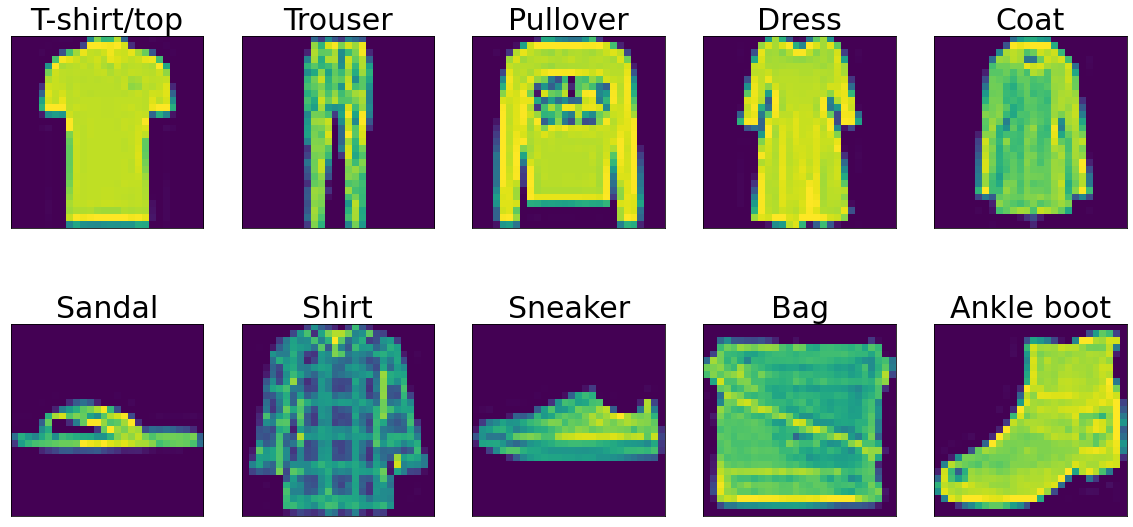

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"examples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.





In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, learning_rate):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.learning_rate = learning_rate
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))



  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def tanh_derivate(self,X):
    # Utility to compute tanh derivative
    return 1 - (np.tanh(X) ** 2)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def relu_derivative(self,X):
    # Utility to compute relu derivative
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')


    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def gradient_descent(self):
    for i in range(len(self.hidden_layer_sizes)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        self.weights[i+1] = self.weights[i+1] - self.learning_rate * self.dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        self.biases[i+1] = self.biases[i+1] - self.learning_rate * self.db[i+1]
    return 



  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()

model = FeedForwardNeuralNetwork([100,256, 512], 10, 0.0001)

model.fit(x_train[0:10000], y_encoded[0:10000])

Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
Epoch:  7  Loss:  194.9111013237063116
Epoch:  8  Loss:  202.96914933221613472
Epoch:  9  Loss:  242.3250418288858484


In [ ]:
#Check predictions for first 10 datapoints
for i in range(10):
  print(model.predict(x_train[i]))
  print(y_encoded[i])


[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Issue might be in sending dw_i to the functions (check call by value or call by reference)

##Question 3

In [ ]:
##Create classes for loss functions
#cross entropy loss

#Create classes for optimizers
#1.SGD
#2.NAG
#3.Momentum
#4.rmsprop
#7.adam
#6.nadam


In [ ]:
def accuracy(y_true, y_pred):
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random", log=0):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []
    self.log = log

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
        # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
        # Creates a row of biases corresponding to each weight of the layer

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    #self.H[0] = self.H[0].astype('float128')

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.H[i]), self.dH[i])    
    return


  def fit(self, X, Y, X_val, Y_val):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          count = 0
          self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      #self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      training_loss = self.loss_function.compute_loss(Y, y_preds)
      validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation)
      training_accuracy = accuracy(np.argmax(Y,1), np.argmax(y_preds,1))
      validation_accuracy = accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
      if self.log==1:
        #Log metrics to wandb
        wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})

      print("Epoch: ",e+1," Training Loss: ",training_loss, " Validation Loss:",validation_loss ," Training Accuracy: ",training_accuracy, " Validation Accuracy:", validation_accuracy)
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def predict(self, X):
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


In [ ]:
class GD():
  def __init__(self, learning_rate = 0.001):
    self.learning_rate = learning_rate

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
  
  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    for i in range(len(layers)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


class MomentumGD():
  def __init__(self, learning_rate = 0.001, gamma = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    for i in range(len(layers)+1):
        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class NAG():
  def __init__(self, learning_rate = 0.001, gamma = 0.9):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
    self.dw_look_ahead={}
    self.db_look_ahead={}

  def optimizer_name(self):
    return "nag"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    self.dw_look_ahead.clear()
    self.dw_look_ahead.clear()

    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.dw_look_ahead.clear[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.db_look_ahead.clear[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    
    for i in range(len(layers)+1):
        self.dw_look_ahead[i+1] = self.weights[i+1] - self.gamma*self.update_history_w[i+1]
        self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] + self.learning_rate*dw_look_ahead[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.db_look_ahead[i+1] = self.biases[i+1] - self.gamma*self.update_history_b[i+1]
        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db_look_ahead[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, v_w = 0.001, v_b = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    # self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    # self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    #if self.initialized == False:
      #self.initialized = True
      #print(weights[1].shape[0])
      #print(weights[len(weights)].shape[-1])
      #all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
      #for i in range(len(layers)+1):
      #  self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      #  self.v_b[i+1] = np.zeros((1, all_layers[i+1]))

    for i in range(len(layers)+1):
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Adam():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1;

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def optimizer_name(self):
    return "adam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(m_w_hat)
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(m_b_hat)

    self.iterations += 1
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1;

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


In [ ]:
class Sigmoid():
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    return X*(1-X)

class Softmax():
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    #Here X is the activation value
    #softmax = self.compute_activation(X)
    return X*(1-X)

class Tanh():
  def compute_activation(self,X):
    return np.tanh(X)

  def compute_derivative(self,X):
    return 1 - (np.tanh(X) ** 2)

class ReLU():
  def relu(self,X):
    return X * (X > 0)

  def relu_derivative(self,X):
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X

In [ ]:
class CrossEntropy():
  def compute_loss(self, Y_true, Y_pred):
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder

#One hot encoding of the class labels
#encoder = OneHotEncoder()
#y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()


#Add layer sizes for the hidden layers
layers = [64,32,64]


#all_layers = [x_train.shape[1]*x_train.shape[1]] + layers + [y_encoded.shape[1]]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "ReLU":ReLU()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.0001}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.002}
optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.0001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.0005, "gamma":0.001, "epsilon":1e-8}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]


#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]
activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
activation_ReLU = activation_functions["ReLU"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]


model = FeedForwardNeuralNetwork(layers, optimizer_rmsprop, loss_cross_entropy, activation_sigmoid, output_activation_softmax, 10, 512, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  2.1424097448205175  Validation Loss: 1.9477466216316763  Training Accuracy:  0.4426481481481481  Validation Accuracy: 0.5733333333333334
Epoch:  2  Training Loss:  1.7235270470473663  Validation Loss: 1.4916228629504082  Training Accuracy:  0.5842777777777778  Validation Accuracy: 0.5938333333333333
Epoch:  3  Training Loss:  1.3049053174685699  Validation Loss: 1.1450108563151906  Training Accuracy:  0.6274074074074074  Validation Accuracy: 0.6671666666666667
Epoch:  4  Training Loss:  1.0228792515103864  Validation Loss: 0.9261810261409693  Training Accuracy:  0.6922407407407407  Validation Accuracy: 0.692
Epoch:  5  Training Loss:  0.84866025536843  Validation Loss: 0.7944383162215068  Training Accuracy:  0.7265185185185186  Validation Accuracy: 0.7285
Epoch:  6  Training Loss:  0.7436694003858354  Validation Loss: 0.7164528599541093  Training Accuracy:  0.7487962962962963  Validation Accuracy: 0.7491666666666666
Epoch:  7  Training Loss:  0.67509303906708

(0.5683804353240365,
 0.5813408934521596,
 0.8057962962962963,
 0.7941666666666667)

In [ ]:
#Check predictions for first 10 datapoints
#for i in range(10):
y_preds = model.predict(x_test)
print(accuracy(y_test, y_preds))


0.0



Ref : https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

For Sigmoid/Tanh --> Use Xavier

Xavier Normal: For the normal distribution the limit value is constructed by averaging the Fin and Fout together and then taking the square-root (Jones, 2016). A zero-center (µ = 0) is then used:

Xavier Uniform: 

For Relu ---> Use He

Weight_decay --> beta2 in adam/nadam

##Question 4 : Wandb plots and hyperparameter tuning

In [ ]:
sweep_config = {
    #GridSearch over the hyperparameters
    'method': 'grid',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
        },
        'activation': {
            'values': ['sigmoid' , 'tanh', 'ReLU']
        },
        #'output_activation': {
        #    'values': ['softmax']
        #},
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: kiiqyemv
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/kiiqyemv


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        #'output_activation': 'softmax',
        'batch_size':100
    }

    # Initialize a new wandb run
    wandb.init(project='Assignment_1',config=config_defaults)

    #Setting custom run name 
    wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers' + str(len(config.hidden_layers)) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    learning_rate = config.learning_rate
    epochs = config.epochs
    hidden_layers = config.hidden_layers

    if config.activation=="sigmoid":
      activation = activation_sigmoid
    
    if config.activation=="tanh":
      activation = activation_tanh

    if config.activation=="ReLU":
      activation = activation_ReLU
    #activation = config.activation

    #if config.output_activation=="softmax":
    #  output_activation = output_activation_softmax
    #output_activation = config.output_activation
    output_activation = output_activation_softmax

    if config.optimizer=="sgd":
      #Select optimizer(sgd)
      optimizer_sgd = optimizers["gradient_descent"]
      optimizer_parameters_sgd = {"learning_rate":config.learning_rate}
      optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)
      optimizer = optimizer_sgd
    if config.optimizer=="momentum":
      #Select optimizer(momentum)
      optimizer_momentum = optimizers["momentum_gd"]
      optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":0.002}
      optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)
      optimizer = optimizer_momentum
    if config.optimizer=="nag":
      #Select optimizer(momentum)
      optimizer_nag = optimizers["nag"]
      optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":0.9}
      optimizer_nag.set_initial_parameters(optimizer_parameters_nag)
      optimizer = optimizer_nag
    if config.optimizer=="rmsprop":
      #Select optimizer(rmsprop)
      optimizer_rmsprop = optimizers["rmsprop"]
      optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":0.001, "epsilon":1e-8}
      optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)
      optimizer = optimizer_rmsprop
    if config.optimizer=="adam":
      #Select optimizer(adam)
      optimizer_adam = optimizers["adam"]
      optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
      optimizer_adam.set_initial_parameters(optimizer_parameters_adam)
      optimizer = optimizer_adam
    if config.optimizer=="nadam":
      #Select optimizer(nadam)
      optimizer_nadam = optimizers["nadam"]
      optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
      optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
      optimizer = optimizer_nadam
    #optimizer = config.optimizer
    batch_size = config.batch_size

    #Model training 
    #Ensure that log=1 parameter is set for logging onto wandb
    model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1)
    train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)



In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: w9r3pe16 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Agent Starting Run: p09gest9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: v08q04z8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ns5vkt1o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.191993532997601  Validation Loss: 2.0250279540639964  Training Accuracy:  0.3177  Validation Accuracy: 0.4951
Epoch:  1  Training Loss:  1.8836760676623845  Validation Loss: 1.741147073942631  Training Accuracy:  0.53  Validation Accuracy: 0.5892
Epoch:  2  Training Loss:  1.625746531345784  Validation Loss: 1.5224414966353677  Training Accuracy:  0.5788  Validation Accuracy: 0.6323
Epoch:  3  Training Loss:  1.433389884360487  Validation Loss: 1.3592377044040769  Training Accuracy:  0.6126  Validation Accuracy: 0.6415
Epoch:  4  Training Loss:  1.2901227015132093  Validation Loss: 1.224174110777331  Training Accuracy:  0.6386  Validation Accuracy: 0.6482


accuracy,▁
accuracy,0.6386


wandb: Agent Starting Run: cybeqkb2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u5u0cgqc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: jk7vp98d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsav4ul8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9438147152405225  Validation Loss: 1.7154682584929284  Training Accuracy:  0.4609  Validation Accuracy: 0.5864
Epoch:  1  Training Loss:  1.5852190238006536  Validation Loss: 1.473571488476001  Training Accuracy:  0.5638  Validation Accuracy: 0.6093
Epoch:  2  Training Loss:  1.3899775572904336  Validation Loss: 1.3113880737812929  Training Accuracy:  0.6095  Validation Accuracy: 0.6481
Epoch:  3  Training Loss:  1.2592228672184766  Validation Loss: 1.205720620121183  Training Accuracy:  0.6301  Validation Accuracy: 0.6348
Epoch:  4  Training Loss:  1.161845144485138  Validation Loss: 1.1141518875305916  Training Accuracy:  0.6388  Validation Accuracy: 0.6464


accuracy,▁
accuracy,0.6388


wandb: Agent Starting Run: voxm1lp3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Agent Starting Run: naeicxvs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: 55o7kh0j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Agent Starting Run: 3wqj5yii with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9531694964990485  Validation Loss: 1.7421455923049252  Training Accuracy:  0.4338  Validation Accuracy: 0.5522
Epoch:  1  Training Loss:  1.6255821228648704  Validation Loss: 1.5238930111199638  Training Accuracy:  0.5521  Validation Accuracy: 0.5916
Epoch:  2  Training Loss:  1.4481727251702896  Validation Loss: 1.3795527415882156  Training Accuracy:  0.5862  Validation Accuracy: 0.6086
Epoch:  3  Training Loss:  1.3220621385260878  Validation Loss: 1.2649922618218543  Training Accuracy:  0.6039  Validation Accuracy: 0.6237
Epoch:  4  Training Loss:  1.2111292246917795  Validation Loss: 1.1576240633595265  Training Accuracy:  0.6256  Validation Accuracy: 0.6548


accuracy,▁
accuracy,0.6256


wandb: Agent Starting Run: hodppqk6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: zm7jt6u7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: 7xvv7wu4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Agent Starting Run: t33gev4m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9898572156182246  Validation Loss: 1.7267968058742107  Training Accuracy:  0.2964  Validation Accuracy: 0.3803
Epoch:  1  Training Loss:  1.6157616578624605  Validation Loss: 1.5207826096068362  Training Accuracy:  0.4116  Validation Accuracy: 0.4471
Epoch:  2  Training Loss:  1.4408381673690227  Validation Loss: 1.3649003182329458  Training Accuracy:  0.4295  Validation Accuracy: 0.4464
Epoch:  3  Training Loss:  1.3105772386428172  Validation Loss: 1.2556834093736688  Training Accuracy:  0.4739  Validation Accuracy: 0.5181
Epoch:  4  Training Loss:  1.2190883013292122  Validation Loss: 1.1851967642510266  Training Accuracy:  0.5401  Validation Accuracy: 0.5522


accuracy,▁
accuracy,0.5401


wandb: Agent Starting Run: 0v18bnyk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: 84lg3f3p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: pvqa3h1x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Agent Starting Run: dq26v3nm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9814187653773239  Validation Loss: 1.7264703158076802  Training Accuracy:  0.3118  Validation Accuracy: 0.3531
Epoch:  1  Training Loss:  1.616069367388577  Validation Loss: 1.529071519618662  Training Accuracy:  0.4107  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.4548139326049891  Validation Loss: 1.3785549243301713  Training Accuracy:  0.4312  Validation Accuracy: 0.52
Epoch:  3  Training Loss:  1.3197127157937754  Validation Loss: 1.2657702805456261  Training Accuracy:  0.4693  Validation Accuracy: 0.5142
Epoch:  4  Training Loss:  1.2289011661871239  Validation Loss: 1.1874685739400528  Training Accuracy:  0.5076  Validation Accuracy: 0.5589


accuracy,▁
accuracy,0.5076


wandb: Agent Starting Run: xwrwm5p5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: j3yscpi0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: yjc21tmb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvf3gwck with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9898300767007528  Validation Loss: 1.7282261512771677  Training Accuracy:  0.3042  Validation Accuracy: 0.4022
Epoch:  1  Training Loss:  1.6102759847627206  Validation Loss: 1.508046156418441  Training Accuracy:  0.4482  Validation Accuracy: 0.5611
Epoch:  2  Training Loss:  1.4236211419242086  Validation Loss: 1.3419415035684052  Training Accuracy:  0.4979  Validation Accuracy: 0.5601
Epoch:  3  Training Loss:  1.276335962575765  Validation Loss: 1.213759035377321  Training Accuracy:  0.5596  Validation Accuracy: 0.6157
Epoch:  4  Training Loss:  1.1685025185523326  Validation Loss: 1.122266198745469  Training Accuracy:  0.5932  Validation Accuracy: 0.6463


accuracy,▁
accuracy,0.5932


wandb: Agent Starting Run: qnmflm30 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Agent Starting Run: ga66j1kt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: sngue1wp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: uwu28w9t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9955073185152847  Validation Loss: 1.7059348861440302  Training Accuracy:  0.1915  Validation Accuracy: 0.2189
Epoch:  1  Training Loss:  1.6168417607211123  Validation Loss: 1.5155565915399871  Training Accuracy:  0.33  Validation Accuracy: 0.3463
Epoch:  2  Training Loss:  1.4332795879364557  Validation Loss: 1.3706207613374837  Training Accuracy:  0.3853  Validation Accuracy: 0.3594
Epoch:  3  Training Loss:  1.323421074454023  Validation Loss: 1.287335513208265  Training Accuracy:  0.4112  Validation Accuracy: 0.377
Epoch:  4  Training Loss:  1.2548621576161532  Validation Loss: 1.2321385464991643  Training Accuracy:  0.4284  Validation Accuracy: 0.4426


accuracy,▁
accuracy,0.4284


wandb: Agent Starting Run: km3j8bns with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zaln54iu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: hzemrkca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: u1dxwemu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9926354817464191  Validation Loss: 1.703132363466236  Training Accuracy:  0.1935  Validation Accuracy: 0.2157
Epoch:  1  Training Loss:  1.6054475734641684  Validation Loss: 1.4941212350740802  Training Accuracy:  0.3397  Validation Accuracy: 0.3675
Epoch:  2  Training Loss:  1.4241451276478967  Validation Loss: 1.3662907837597253  Training Accuracy:  0.3899  Validation Accuracy: 0.3561
Epoch:  3  Training Loss:  1.3181845648187416  Validation Loss: 1.2871828149219524  Training Accuracy:  0.4195  Validation Accuracy: 0.378
Epoch:  4  Training Loss:  1.2534996430175576  Validation Loss: 1.2254212097477362  Training Accuracy:  0.4531  Validation Accuracy: 0.4329


accuracy,▁
accuracy,0.4531


wandb: Agent Starting Run: p7lz4sma with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Agent Starting Run: 23x9v22z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: u1nwnsdx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: k1wl2koy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0013281778240097  Validation Loss: 1.7077227216589115  Training Accuracy:  0.1899  Validation Accuracy: 0.2106
Epoch:  1  Training Loss:  1.6375661187544155  Validation Loss: 1.563482779658967  Training Accuracy:  0.2935  Validation Accuracy: 0.3253
Epoch:  2  Training Loss:  1.4793928008788098  Validation Loss: 1.406417392269575  Training Accuracy:  0.3788  Validation Accuracy: 0.3766
Epoch:  3  Training Loss:  1.3567381105999345  Validation Loss: 1.3116327026452261  Training Accuracy:  0.3884  Validation Accuracy: 0.3783
Epoch:  4  Training Loss:  1.2770767389832314  Validation Loss: 1.242998340999263  Training Accuracy:  0.4236  Validation Accuracy: 0.3894


accuracy,▁
accuracy,0.4236


wandb: Agent Starting Run: 4g5iubsl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: kzvqd39x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: ks1s1hvb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: d3zqabv1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9746581898316988  Validation Loss: 1.7665918903354727  Training Accuracy:  0.3989  Validation Accuracy: 0.5129
Epoch:  1  Training Loss:  1.6394367535016052  Validation Loss: 1.52423095669607  Training Accuracy:  0.5181  Validation Accuracy: 0.5947
Epoch:  2  Training Loss:  1.4423678635990906  Validation Loss: 1.3690318783452189  Training Accuracy:  0.5894  Validation Accuracy: 0.6072
Epoch:  3  Training Loss:  1.3073198271787878  Validation Loss: 1.257317957721882  Training Accuracy:  0.609  Validation Accuracy: 0.6296
Epoch:  4  Training Loss:  1.2042320391670434  Validation Loss: 1.1517805496212425  Training Accuracy:  0.6169  Validation Accuracy: 0.631
Epoch:  5  Training Loss:  1.1137264494477734  Validation Loss: 1.0689387502922858  Training Accuracy:  0.6403  Validation Accuracy: 0.6504
Epoch:  6  Training Loss:  1.0390502028031376  Validation Loss: 1.0064602725955465  Training Accuracy:  0.6472  Validation Accuracy: 0.6536
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.6721


wandb: Agent Starting Run: 6yfhacir with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: lll8bd16 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: xnh7289u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: wfog3lqo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.984063696403113  Validation Loss: 1.7830796251460852  Training Accuracy:  0.4248  Validation Accuracy: 0.5895
Epoch:  1  Training Loss:  1.6546065474004954  Validation Loss: 1.5383259678235675  Training Accuracy:  0.5368  Validation Accuracy: 0.6046
Epoch:  2  Training Loss:  1.4552140855191662  Validation Loss: 1.3684048859813776  Training Accuracy:  0.6013  Validation Accuracy: 0.6214
Epoch:  3  Training Loss:  1.310435123235516  Validation Loss: 1.2536415726995154  Training Accuracy:  0.6172  Validation Accuracy: 0.6299
Epoch:  4  Training Loss:  1.1990447276453566  Validation Loss: 1.1549135789316063  Training Accuracy:  0.6324  Validation Accuracy: 0.6436
Epoch:  5  Training Loss:  1.1104621055480066  Validation Loss: 1.071986297743742  Training Accuracy:  0.6466  Validation Accuracy: 0.6561
Epoch:  6  Training Loss:  1.0427121381992424  Validation Loss: 1.0046579327329201  Training Accuracy:  0.6617  Validation Accuracy: 0.6805
Epoch:  7  Training Los

accuracy,▁
accuracy,0.7033


wandb: Agent Starting Run: f4i8juny with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: 6jlyuzed with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: 84a9cn4v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: bwkcnyv0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9658119895629744  Validation Loss: 1.7568383792175326  Training Accuracy:  0.4251  Validation Accuracy: 0.5658
Epoch:  1  Training Loss:  1.6403411722309778  Validation Loss: 1.5436816425403104  Training Accuracy:  0.5417  Validation Accuracy: 0.6052
Epoch:  2  Training Loss:  1.4606485737404589  Validation Loss: 1.3872866490106195  Training Accuracy:  0.5736  Validation Accuracy: 0.6066
Epoch:  3  Training Loss:  1.3242099978744886  Validation Loss: 1.2674728780913715  Training Accuracy:  0.6032  Validation Accuracy: 0.6171
Epoch:  4  Training Loss:  1.2246536463302238  Validation Loss: 1.1789789763534568  Training Accuracy:  0.6161  Validation Accuracy: 0.635
Epoch:  5  Training Loss:  1.1419621220944651  Validation Loss: 1.0951696237208615  Training Accuracy:  0.6201  Validation Accuracy: 0.6312
Epoch:  6  Training Loss:  1.063208793429116  Validation Loss: 1.0398908490056664  Training Accuracy:  0.6349  Validation Accuracy: 0.6374
Epoch:  7  Training Lo

accuracy,▁
accuracy,0.6776


wandb: Agent Starting Run: 37tpwrbp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2572234880580773  Validation Loss: 2.2520638681744045  Training Accuracy:  0.2846  Validation Accuracy: 0.2447
Epoch:  6  Training Loss:  2.248730151776578  Validation Loss: 2.243165703676739  Training Accuracy:  0.3  Validation Accuracy: 0.2536
Epoch:  7  Training Loss:  2.2

accuracy,▁
accuracy,0.3463


wandb: Agent Starting Run: y0jhzh0b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257009992957443  Validation Loss: 2.251626701674166  Training Accuracy:  0.282  Validation Accuracy: 0.2432
Epoch:  6  Training Loss:  2.24823667484881  Validation Loss: 2.2426727183276656  Training Accuracy:  0.2979  Validation Accuracy: 0.2533
Epoch:  7  Training Loss:  2.23878

accuracy,▁
accuracy,0.3426


wandb: Agent Starting Run: 1jcq2fp4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206
Epoch:  5  Training Loss:  0.750458222585209  Validation Loss: 0.7429819392678262  Training Accuracy:  0.7232  Validation Accuracy: 0.7265
Epoch:  6  Training Loss:  0.7425257766488278  Validation Loss: 0.7368968614375584  Training Accuracy:  0.7318  Validation Accuracy: 0.7342
Epoch:  7  Training Loss:  0

accuracy,▁
accuracy,0.7529


wandb: Agent Starting Run: hexfgfm7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9809112786285201  Validation Loss: 1.729694287925806  Training Accuracy:  0.2883  Validation Accuracy: 0.3784
Epoch:  1  Training Loss:  1.6337921903204744  Validation Loss: 1.5533814027972581  Training Accuracy:  0.404  Validation Accuracy: 0.3836
Epoch:  2  Training Loss:  1.4891728366070944  Validation Loss: 1.4249314042233745  Training Accuracy:  0.4275  Validation Accuracy: 0.521
Epoch:  3  Training Loss:  1.3617233187370303  Validation Loss: 1.2966165198362258  Training Accuracy:  0.4671  Validation Accuracy: 0.5192
Epoch:  4  Training Loss:  1.2511990220279703  Validation Loss: 1.2037320360643902  Training Accuracy:  0.531  Validation Accuracy: 0.5577
Epoch:  5  Training Loss:  1.1707102667222142  Validation Loss: 1.1366020730454027  Training Accuracy:  0.5701  Validation Accuracy: 0.5722
Epoch:  6  Training Loss:  1.1100225830766648  Validation Loss: 1.0770108790515966  Training Accuracy:  0.6037  Validation Accuracy: 0.6201
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6493


wandb: Agent Starting Run: cg5uqr2i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2572234880580773  Validation Loss: 2.2520638681744045  Training Accuracy:  0.2846  Validation Accuracy: 0.2447
Epoch:  6  Training Loss:  2.248730151776578  Validation Loss: 2.243165703676739  Training Accuracy:  0.3  Validation Accuracy: 0.2536
Epoch:  7  Training Loss:  2.2

accuracy,▁
accuracy,0.3463


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 20etuqw3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257009992957443  Validation Loss: 2.251626701674166  Training Accuracy:  0.282  Validation Accuracy: 0.2432
Epoch:  6  Training Loss:  2.24823667484881  Validation Loss: 2.2426727183276656  Training Accuracy:  0.2979  Validation Accuracy: 0.2533
Epoch:  7  Training Loss:  2.23878

accuracy,▁
accuracy,0.3426


wandb: Agent Starting Run: wo094w4m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206
Epoch:  5  Training Loss:  0.750458222585209  Validation Loss: 0.7429819392678262  Training Accuracy:  0.7232  Validation Accuracy: 0.7265
Epoch:  6  Training Loss:  0.7425257766488278  Validation Loss: 0.7368968614375584  Training Accuracy:  0.7318  Validation Accuracy: 0.7342
Epoch:  7  Training Loss:  0

accuracy,▁
accuracy,0.7529


wandb: Agent Starting Run: hx8lfxoy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9809112786285201  Validation Loss: 1.729694287925806  Training Accuracy:  0.2883  Validation Accuracy: 0.3784
Epoch:  1  Training Loss:  1.6337921903204744  Validation Loss: 1.5533814027972581  Training Accuracy:  0.404  Validation Accuracy: 0.3836
Epoch:  2  Training Loss:  1.4891728366070944  Validation Loss: 1.4249314042233745  Training Accuracy:  0.4275  Validation Accuracy: 0.521
Epoch:  3  Training Loss:  1.3617233187370303  Validation Loss: 1.2966165198362258  Training Accuracy:  0.4671  Validation Accuracy: 0.5192
Epoch:  4  Training Loss:  1.2511990220279703  Validation Loss: 1.2037320360643902  Training Accuracy:  0.531  Validation Accuracy: 0.5577
Epoch:  5  Training Loss:  1.1707102667222142  Validation Loss: 1.1366020730454027  Training Accuracy:  0.5701  Validation Accuracy: 0.5722
Epoch:  6  Training Loss:  1.1100225830766648  Validation Loss: 1.0770108790515966  Training Accuracy:  0.6037  Validation Accuracy: 0.6201
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6493


wandb: Agent Starting Run: qyy7kk8v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2572234880580773  Validation Loss: 2.2520638681744045  Training Accuracy:  0.2846  Validation Accuracy: 0.2447
Epoch:  6  Training Loss:  2.248730151776578  Validation Loss: 2.243165703676739  Training Accuracy:  0.3  Validation Accuracy: 0.2536
Epoch:  7  Training Loss:  2.2

accuracy,▁
accuracy,0.3463


wandb: Agent Starting Run: xtoso69c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257009992957443  Validation Loss: 2.251626701674166  Training Accuracy:  0.282  Validation Accuracy: 0.2432
Epoch:  6  Training Loss:  2.24823667484881  Validation Loss: 2.2426727183276656  Training Accuracy:  0.2979  Validation Accuracy: 0.2533
Epoch:  7  Training Loss:  2.23878

accuracy,▁
accuracy,0.3426


wandb: Agent Starting Run: qyi1pi9o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206
Epoch:  5  Training Loss:  0.750458222585209  Validation Loss: 0.7429819392678262  Training Accuracy:  0.7232  Validation Accuracy: 0.7265
Epoch:  6  Training Loss:  0.7425257766488278  Validation Loss: 0.7368968614375584  Training Accuracy:  0.7318  Validation Accuracy: 0.7342
Epoch:  7  Training Loss:  0

accuracy,▁
accuracy,0.7529


wandb: Agent Starting Run: fq3y6frx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9809112786285201  Validation Loss: 1.729694287925806  Training Accuracy:  0.2883  Validation Accuracy: 0.3784
Epoch:  1  Training Loss:  1.6337921903204744  Validation Loss: 1.5533814027972581  Training Accuracy:  0.404  Validation Accuracy: 0.3836
Epoch:  2  Training Loss:  1.4891728366070944  Validation Loss: 1.4249314042233745  Training Accuracy:  0.4275  Validation Accuracy: 0.521
Epoch:  3  Training Loss:  1.3617233187370303  Validation Loss: 1.2966165198362258  Training Accuracy:  0.4671  Validation Accuracy: 0.5192
Epoch:  4  Training Loss:  1.2511990220279703  Validation Loss: 1.2037320360643902  Training Accuracy:  0.531  Validation Accuracy: 0.5577
Epoch:  5  Training Loss:  1.1707102667222142  Validation Loss: 1.1366020730454027  Training Accuracy:  0.5701  Validation Accuracy: 0.5722
Epoch:  6  Training Loss:  1.1100225830766648  Validation Loss: 1.0770108790515966  Training Accuracy:  0.6037  Validation Accuracy: 0.6201
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6493


wandb: Agent Starting Run: kyq0mok6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135
Epoch:  5  Training Loss:  2.301947583963586  Validation Loss: 2.3005579043997098  Training Accuracy:  0.1134  Validation Accuracy: 0.1365
Epoch:  6  Training Loss:  2.3015757260577865  Validation Loss: 2.3001892943155866  Training Accuracy:  0.1138  Validation Accuracy: 0.1371
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.117


wandb: Agent Starting Run: 9sbs20ib with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348
Epoch:  5  Training Loss:  2.3019461000013206  Validation Loss: 2.3005561376597945  Training Accuracy:  0.1133  Validation Accuracy: 0.1362
Epoch:  6  Training Loss:  2.301574714911731  Validation Loss: 2.3001864601817013  Training Accuracy:  0.1136  Validation Accuracy: 0.1365
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.1172


wandb: Agent Starting Run: pb7yrtgj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806
Epoch:  5  Training Loss:  0.983789326580341  Validation Loss: 0.9908848559817556  Training Accuracy:  0.5959  Validation Accuracy: 0.582
Epoch:  6  Training Loss:  0.9972706243892971  Validation Loss: 0.9890770675015635  Training Accuracy:  0.5974  Validation Accuracy: 0.5844
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.68


wandb: Agent Starting Run: 8luc7n9z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0008825888765767  Validation Loss: 1.7095665425071183  Training Accuracy:  0.1891  Validation Accuracy: 0.2154
Epoch:  1  Training Loss:  1.6369091249361782  Validation Loss: 1.5559524487018266  Training Accuracy:  0.2997  Validation Accuracy: 0.3329
Epoch:  2  Training Loss:  1.4740017991916876  Validation Loss: 1.3996051600943835  Training Accuracy:  0.3823  Validation Accuracy: 0.3672
Epoch:  3  Training Loss:  1.342355211919924  Validation Loss: 1.2996060022409859  Training Accuracy:  0.3971  Validation Accuracy: 0.3863
Epoch:  4  Training Loss:  1.2678218458591022  Validation Loss: 1.2312007834921181  Training Accuracy:  0.4211  Validation Accuracy: 0.3884
Epoch:  5  Training Loss:  1.2146035308460044  Validation Loss: 1.195418708931494  Training Accuracy:  0.4484  Validation Accuracy: 0.4782
Epoch:  6  Training Loss:  1.1855643602374322  Validation Loss: 1.1587309570678905  Training Accuracy:  0.4659  Validation Accuracy: 0.4983
Epoch:  7  Training Lo

accuracy,▁
accuracy,0.5424


wandb: Agent Starting Run: fb2mnq2y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135
Epoch:  5  Training Loss:  2.301947583963586  Validation Loss: 2.3005579043997098  Training Accuracy:  0.1134  Validation Accuracy: 0.1365
Epoch:  6  Training Loss:  2.3015757260577865  Validation Loss: 2.3001892943155866  Training Accuracy:  0.1138  Validation Accuracy: 0.1371
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.117


wandb: Agent Starting Run: r3io60az with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348
Epoch:  5  Training Loss:  2.3019461000013206  Validation Loss: 2.3005561376597945  Training Accuracy:  0.1133  Validation Accuracy: 0.1362
Epoch:  6  Training Loss:  2.301574714911731  Validation Loss: 2.3001864601817013  Training Accuracy:  0.1136  Validation Accuracy: 0.1365
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.1172


wandb: Agent Starting Run: hixyxm6z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806
Epoch:  5  Training Loss:  0.983789326580341  Validation Loss: 0.9908848559817556  Training Accuracy:  0.5959  Validation Accuracy: 0.582
Epoch:  6  Training Loss:  0.9972706243892971  Validation Loss: 0.9890770675015635  Training Accuracy:  0.5974  Validation Accuracy: 0.5844
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.68


wandb: Agent Starting Run: r0hah779 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0008825888765767  Validation Loss: 1.7095665425071183  Training Accuracy:  0.1891  Validation Accuracy: 0.2154
Epoch:  1  Training Loss:  1.6369091249361782  Validation Loss: 1.5559524487018266  Training Accuracy:  0.2997  Validation Accuracy: 0.3329
Epoch:  2  Training Loss:  1.4740017991916876  Validation Loss: 1.3996051600943835  Training Accuracy:  0.3823  Validation Accuracy: 0.3672
Epoch:  3  Training Loss:  1.342355211919924  Validation Loss: 1.2996060022409859  Training Accuracy:  0.3971  Validation Accuracy: 0.3863
Epoch:  4  Training Loss:  1.2678218458591022  Validation Loss: 1.2312007834921181  Training Accuracy:  0.4211  Validation Accuracy: 0.3884
Epoch:  5  Training Loss:  1.2146035308460044  Validation Loss: 1.195418708931494  Training Accuracy:  0.4484  Validation Accuracy: 0.4782
Epoch:  6  Training Loss:  1.1855643602374322  Validation Loss: 1.1587309570678905  Training Accuracy:  0.4659  Validation Accuracy: 0.4983
Epoch:  7  Training Lo

accuracy,▁
accuracy,0.5424


wandb: Agent Starting Run: c2kdos3r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135
Epoch:  5  Training Loss:  2.301947583963586  Validation Loss: 2.3005579043997098  Training Accuracy:  0.1134  Validation Accuracy: 0.1365
Epoch:  6  Training Loss:  2.3015757260577865  Validation Loss: 2.3001892943155866  Training Accuracy:  0.1138  Validation Accuracy: 0.1371
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.117


wandb: Agent Starting Run: wiwju7uf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348
Epoch:  5  Training Loss:  2.3019461000013206  Validation Loss: 2.3005561376597945  Training Accuracy:  0.1133  Validation Accuracy: 0.1362
Epoch:  6  Training Loss:  2.301574714911731  Validation Loss: 2.3001864601817013  Training Accuracy:  0.1136  Validation Accuracy: 0.1365
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.1172


wandb: Agent Starting Run: frhsss8g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806
Epoch:  5  Training Loss:  0.983789326580341  Validation Loss: 0.9908848559817556  Training Accuracy:  0.5959  Validation Accuracy: 0.582
Epoch:  6  Training Loss:  0.9972706243892971  Validation Loss: 0.9890770675015635  Training Accuracy:  0.5974  Validation Accuracy: 0.5844
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.68


wandb: Agent Starting Run: gqzup8v5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0008825888765767  Validation Loss: 1.7095665425071183  Training Accuracy:  0.1891  Validation Accuracy: 0.2154
Epoch:  1  Training Loss:  1.6369091249361782  Validation Loss: 1.5559524487018266  Training Accuracy:  0.2997  Validation Accuracy: 0.3329
Epoch:  2  Training Loss:  1.4740017991916876  Validation Loss: 1.3996051600943835  Training Accuracy:  0.3823  Validation Accuracy: 0.3672
Epoch:  3  Training Loss:  1.342355211919924  Validation Loss: 1.2996060022409859  Training Accuracy:  0.3971  Validation Accuracy: 0.3863
Epoch:  4  Training Loss:  1.2678218458591022  Validation Loss: 1.2312007834921181  Training Accuracy:  0.4211  Validation Accuracy: 0.3884
Epoch:  5  Training Loss:  1.2146035308460044  Validation Loss: 1.195418708931494  Training Accuracy:  0.4484  Validation Accuracy: 0.4782
Epoch:  6  Training Loss:  1.1855643602374322  Validation Loss: 1.1587309570678905  Training Accuracy:  0.4659  Validation Accuracy: 0.4983
Epoch:  7  Training Lo

accuracy,▁
accuracy,0.5424


wandb: Agent Starting Run: y2rvvmli with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542


accuracy,▁
accuracy,0.5105


wandb: Agent Starting Run: ic89g21u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192


accuracy,▁
accuracy,0.4928


wandb: Agent Starting Run: smiu8rca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729


accuracy,▁
accuracy,0.7065


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sverbc36 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163


accuracy,▁
accuracy,0.5908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bcmu6ckf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542


accuracy,▁
accuracy,0.5105


wandb: Agent Starting Run: onr7iymn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192


accuracy,▁
accuracy,0.4928


wandb: Agent Starting Run: x63xd4be with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729


accuracy,▁
accuracy,0.7065


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xphneouu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163


accuracy,▁
accuracy,0.5908


wandb: Agent Starting Run: g1ir4evq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542


accuracy,▁
accuracy,0.5105


wandb: Agent Starting Run: zc83u6l6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192


accuracy,▁
accuracy,0.4928


wandb: Agent Starting Run: 1pf3hpcz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729


accuracy,▁
accuracy,0.7065


wandb: Agent Starting Run: zmtp5xlf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163


accuracy,▁
accuracy,0.5908


wandb: Agent Starting Run: it3v75hy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: z4pncp3z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2687


wandb: Agent Starting Run: j319wkkz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036


accuracy,▁
accuracy,0.6769


wandb: Agent Starting Run: wdst79bb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307


accuracy,▁
accuracy,0.494


wandb: Agent Starting Run: ynfdh8vi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: aqq8yimm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2687


wandb: Agent Starting Run: 0xsawks5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036


accuracy,▁
accuracy,0.6769


wandb: Agent Starting Run: cf4vc2ys with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307


accuracy,▁
accuracy,0.494


wandb: Agent Starting Run: 6tf920za with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8xsugnt4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2687


wandb: Agent Starting Run: i5wv7fgx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036


accuracy,▁
accuracy,0.6769


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7rcfwuo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307


accuracy,▁
accuracy,0.494


wandb: Agent Starting Run: j72y5adi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333


accuracy,▁
accuracy,0.1106


wandb: Agent Starting Run: h937d5j5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133


accuracy,▁
accuracy,0.1105


wandb: Agent Starting Run: vzzwoswl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452


accuracy,▁
accuracy,0.5277


wandb: Agent Starting Run: 53w5vrvz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369


accuracy,▁
accuracy,0.3976


wandb: Agent Starting Run: ekkoqp4g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333


accuracy,▁
accuracy,0.1106


wandb: Agent Starting Run: ifljlugl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133


accuracy,▁
accuracy,0.1105


wandb: Agent Starting Run: hejt5ea5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452


accuracy,▁
accuracy,0.5277


wandb: Agent Starting Run: xle0k8gc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369


accuracy,▁
accuracy,0.3976


wandb: Agent Starting Run: 5d2eb4ty with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333


accuracy,▁
accuracy,0.1106


wandb: Agent Starting Run: 4xlns8se with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133


accuracy,▁
accuracy,0.1105


wandb: Agent Starting Run: t1hudmox with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452


accuracy,▁
accuracy,0.5277


wandb: Agent Starting Run: 9nft9tq1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369


accuracy,▁
accuracy,0.3976


wandb: Agent Starting Run: 2nvrf1jc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542
Epoch:  5  Training Loss:  1.9624513042789047  Validation Loss: 1.9323793238497267  Training Accuracy:  0.5277  Validation Accuracy: 0.5732
Epoch:  6  Training Loss:  1.902735850594291  Validation Loss: 1.868574170074528  Training Accuracy:  0.564  Validation Accuracy: 0.6015
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.5975


wandb: Agent Starting Run: 54lflf21 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192
Epoch:  5  Training Loss:  1.9602496290166687  Validation Loss: 1.929521955418665  Training Accuracy:  0.5181  Validation Accuracy: 0.5396
Epoch:  6  Training Loss:  1.901916474683784  Validation Loss: 1.8696614771685087  Training Accuracy:  0.542  Validation Accuracy: 0.5821
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5997


wandb: Agent Starting Run: yaugj22z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729
Epoch:  5  Training Loss:  0.7590588170172023  Validation Loss: 0.7219429023109559  Training Accuracy:  0.7254  Validation Accuracy: 0.7409
Epoch:  6  Training Loss:  0.7178761949859541  Validation Loss: 0.7002756884941026  Training Accuracy:  0.739  Validation Accuracy: 0.7459
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0gcsobm5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163
Epoch:  5  Training Loss:  1.251662255296876  Validation Loss: 1.2160554425585872  Training Accuracy:  0.6074  Validation Accuracy: 0.6175
Epoch:  6  Training Loss:  1.192844225437444  Validation Loss: 1.1627354885134078  Training Accuracy:  0.6141  Validation Accuracy: 0.644
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mnr7wecm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542
Epoch:  5  Training Loss:  1.9624513042789047  Validation Loss: 1.9323793238497267  Training Accuracy:  0.5277  Validation Accuracy: 0.5732
Epoch:  6  Training Loss:  1.902735850594291  Validation Loss: 1.868574170074528  Training Accuracy:  0.564  Validation Accuracy: 0.6015
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.5975


wandb: Agent Starting Run: x3ipuzc6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192
Epoch:  5  Training Loss:  1.9602496290166687  Validation Loss: 1.929521955418665  Training Accuracy:  0.5181  Validation Accuracy: 0.5396
Epoch:  6  Training Loss:  1.901916474683784  Validation Loss: 1.8696614771685087  Training Accuracy:  0.542  Validation Accuracy: 0.5821
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5997


wandb: Agent Starting Run: kuig2uet with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729
Epoch:  5  Training Loss:  0.7590588170172023  Validation Loss: 0.7219429023109559  Training Accuracy:  0.7254  Validation Accuracy: 0.7409
Epoch:  6  Training Loss:  0.7178761949859541  Validation Loss: 0.7002756884941026  Training Accuracy:  0.739  Validation Accuracy: 0.7459
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7598


wandb: Agent Starting Run: gedx4lvx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163
Epoch:  5  Training Loss:  1.251662255296876  Validation Loss: 1.2160554425585872  Training Accuracy:  0.6074  Validation Accuracy: 0.6175
Epoch:  6  Training Loss:  1.192844225437444  Validation Loss: 1.1627354885134078  Training Accuracy:  0.6141  Validation Accuracy: 0.644
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.667


wandb: Agent Starting Run: 4grz7uzv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.301678320826655  Validation Loss: 2.2191166053017257  Training Accuracy:  0.2208  Validation Accuracy: 0.3254
Epoch:  1  Training Loss:  2.185005664783808  Validation Loss: 2.155231033987448  Training Accuracy:  0.3898  Validation Accuracy: 0.4574
Epoch:  2  Training Loss:  2.1291675534734282  Validation Loss: 2.1009567629315136  Training Accuracy:  0.4506  Validation Accuracy: 0.4874
Epoch:  3  Training Loss:  2.0761873240806334  Validation Loss: 2.0468502531246924  Training Accuracy:  0.4811  Validation Accuracy: 0.5082
Epoch:  4  Training Loss:  2.0210636167859075  Validation Loss: 1.9901772621749523  Training Accuracy:  0.5105  Validation Accuracy: 0.5542
Epoch:  5  Training Loss:  1.9624513042789047  Validation Loss: 1.9323793238497267  Training Accuracy:  0.5277  Validation Accuracy: 0.5732
Epoch:  6  Training Loss:  1.902735850594291  Validation Loss: 1.868574170074528  Training Accuracy:  0.564  Validation Accuracy: 0.6015
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.5975


wandb: Agent Starting Run: 4rssstbn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3042862868843432  Validation Loss: 2.2244699253382265  Training Accuracy:  0.2081  Validation Accuracy: 0.2971
Epoch:  1  Training Loss:  2.1869527235866104  Validation Loss: 2.1546017270323814  Training Accuracy:  0.3506  Validation Accuracy: 0.4093
Epoch:  2  Training Loss:  2.128503237096079  Validation Loss: 2.100241781491624  Training Accuracy:  0.4325  Validation Accuracy: 0.4449
Epoch:  3  Training Loss:  2.0744122126483333  Validation Loss: 2.044219170035777  Training Accuracy:  0.456  Validation Accuracy: 0.4991
Epoch:  4  Training Loss:  2.0182229516407815  Validation Loss: 1.988510461675224  Training Accuracy:  0.4928  Validation Accuracy: 0.5192
Epoch:  5  Training Loss:  1.9602496290166687  Validation Loss: 1.929521955418665  Training Accuracy:  0.5181  Validation Accuracy: 0.5396
Epoch:  6  Training Loss:  1.901916474683784  Validation Loss: 1.8696614771685087  Training Accuracy:  0.542  Validation Accuracy: 0.5821
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5997


wandb: Agent Starting Run: r3gjhnwf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9427018880651337  Validation Loss: 1.5718710551396655  Training Accuracy:  0.4362  Validation Accuracy: 0.588
Epoch:  1  Training Loss:  1.34712570401913  Validation Loss: 1.1599976104889587  Training Accuracy:  0.6161  Validation Accuracy: 0.6469
Epoch:  2  Training Loss:  1.0512332557723538  Validation Loss: 0.9493611970358725  Training Accuracy:  0.6529  Validation Accuracy: 0.6676
Epoch:  3  Training Loss:  0.8982550911094193  Validation Loss: 0.8403400163203647  Training Accuracy:  0.6774  Validation Accuracy: 0.7148
Epoch:  4  Training Loss:  0.8123660425817865  Validation Loss: 0.7658934233608626  Training Accuracy:  0.7065  Validation Accuracy: 0.729
Epoch:  5  Training Loss:  0.7590588170172023  Validation Loss: 0.7219429023109559  Training Accuracy:  0.7254  Validation Accuracy: 0.7409
Epoch:  6  Training Loss:  0.7178761949859541  Validation Loss: 0.7002756884941026  Training Accuracy:  0.739  Validation Accuracy: 0.7459
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7598


wandb: Agent Starting Run: 1p4h5agd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.985920164170858  Validation Loss: 1.7989372547899267  Training Accuracy:  0.4162  Validation Accuracy: 0.4546
Epoch:  1  Training Loss:  1.6782277700580195  Validation Loss: 1.582190049386227  Training Accuracy:  0.4982  Validation Accuracy: 0.5728
Epoch:  2  Training Loss:  1.5171675278190377  Validation Loss: 1.4554953503728547  Training Accuracy:  0.5599  Validation Accuracy: 0.5977
Epoch:  3  Training Loss:  1.4070406862345315  Validation Loss: 1.3613663194148826  Training Accuracy:  0.5825  Validation Accuracy: 0.5892
Epoch:  4  Training Loss:  1.3198491001939634  Validation Loss: 1.2882585028147384  Training Accuracy:  0.5908  Validation Accuracy: 0.6163
Epoch:  5  Training Loss:  1.251662255296876  Validation Loss: 1.2160554425585872  Training Accuracy:  0.6074  Validation Accuracy: 0.6175
Epoch:  6  Training Loss:  1.192844225437444  Validation Loss: 1.1627354885134078  Training Accuracy:  0.6141  Validation Accuracy: 0.644
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.667


wandb: Agent Starting Run: tk9zmsh8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2577118469691193  Validation Loss: 2.252619974281654  Training Accuracy:  0.2825  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.24923083577451  Validation Loss: 2.2437102414761743  Training Accuracy:  0.2965  Validation Accuracy: 0.252
Epoch:  7  Training Loss:  2.23

accuracy,▁
accuracy,0.3381


wandb: Agent Starting Run: i48ttaur with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257465222639646  Validation Loss: 2.2522270057965974  Training Accuracy:  0.2817  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.2488129778737536  Validation Loss: 2.2432629496923053  Training Accuracy:  0.2965  Validation Accuracy: 0.2522
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.342


wandb: Agent Starting Run: 6mxvvca8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036
Epoch:  5  Training Loss:  0.815841343494636  Validation Loss: 0.7795563693148552  Training Accuracy:  0.691  Validation Accuracy: 0.7108
Epoch:  6  Training Loss:  0.766713962427076  Validation Loss: 0.7315713070592565  Training Accuracy:  0.7051  Validation Accuracy: 0.712
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.737


wandb: Agent Starting Run: 7x0nmbzc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307
Epoch:  5  Training Loss:  1.230678349388066  Validation Loss: 1.1960540840389038  Training Accuracy:  0.5251  Validation Accuracy: 0.5449
Epoch:  6  Training Loss:  1.1744622434792698  Validation Loss: 1.14995930953674  Training Accuracy:  0.5427  Validation Accuracy: 0.5637
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.5878


wandb: Agent Starting Run: 8l3shj2a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2577118469691193  Validation Loss: 2.252619974281654  Training Accuracy:  0.2825  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.24923083577451  Validation Loss: 2.2437102414761743  Training Accuracy:  0.2965  Validation Accuracy: 0.252
Epoch:  7  Training Loss:  2.23

accuracy,▁
accuracy,0.3381


wandb: Agent Starting Run: btlirsn2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257465222639646  Validation Loss: 2.2522270057965974  Training Accuracy:  0.2817  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.2488129778737536  Validation Loss: 2.2432629496923053  Training Accuracy:  0.2965  Validation Accuracy: 0.2522
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.342


wandb: Agent Starting Run: 1dw01xxt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036
Epoch:  5  Training Loss:  0.815841343494636  Validation Loss: 0.7795563693148552  Training Accuracy:  0.691  Validation Accuracy: 0.7108
Epoch:  6  Training Loss:  0.766713962427076  Validation Loss: 0.7315713070592565  Training Accuracy:  0.7051  Validation Accuracy: 0.712
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.737


wandb: Agent Starting Run: cp1rh016 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307
Epoch:  5  Training Loss:  1.230678349388066  Validation Loss: 1.1960540840389038  Training Accuracy:  0.5251  Validation Accuracy: 0.5449
Epoch:  6  Training Loss:  1.1744622434792698  Validation Loss: 1.14995930953674  Training Accuracy:  0.5427  Validation Accuracy: 0.5637
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.5878


wandb: Agent Starting Run: jnrghbi1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171928232136625  Validation Loss: 2.290999656423236  Training Accuracy:  0.1048  Validation Accuracy: 0.1174
Epoch:  1  Training Loss:  2.2878554650949874  Validation Loss: 2.2827589280562504  Training Accuracy:  0.1749  Validation Accuracy: 0.163
Epoch:  2  Training Loss:  2.28052018764459  Validation Loss: 2.27626471941332  Training Accuracy:  0.2136  Validation Accuracy: 0.2012
Epoch:  3  Training Loss:  2.273458083335491  Validation Loss: 2.2685978299770113  Training Accuracy:  0.2481  Validation Accuracy: 0.2222
Epoch:  4  Training Loss:  2.2656442477898278  Validation Loss: 2.2607745719068726  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2577118469691193  Validation Loss: 2.252619974281654  Training Accuracy:  0.2825  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.24923083577451  Validation Loss: 2.2437102414761743  Training Accuracy:  0.2965  Validation Accuracy: 0.252
Epoch:  7  Training Loss:  2.23

accuracy,▁
accuracy,0.3381


wandb: Agent Starting Run: mq17iu0r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171448697243724  Validation Loss: 2.290987176073339  Training Accuracy:  0.1051  Validation Accuracy: 0.1173
Epoch:  1  Training Loss:  2.287704354969703  Validation Loss: 2.2824719598720775  Training Accuracy:  0.1752  Validation Accuracy: 0.165
Epoch:  2  Training Loss:  2.280283942402959  Validation Loss: 2.275946636633735  Training Accuracy:  0.2174  Validation Accuracy: 0.2031
Epoch:  3  Training Loss:  2.273150031946035  Validation Loss: 2.2683030753594475  Training Accuracy:  0.2488  Validation Accuracy: 0.2242
Epoch:  4  Training Loss:  2.2654132168301757  Validation Loss: 2.2605449806226554  Training Accuracy:  0.2687  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257465222639646  Validation Loss: 2.2522270057965974  Training Accuracy:  0.2817  Validation Accuracy: 0.2433
Epoch:  6  Training Loss:  2.2488129778737536  Validation Loss: 2.2432629496923053  Training Accuracy:  0.2965  Validation Accuracy: 0.2522
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: umrrdopb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.026856672383187  Validation Loss: 1.662524770033748  Training Accuracy:  0.2746  Validation Accuracy: 0.3035
Epoch:  1  Training Loss:  1.445872100854257  Validation Loss: 1.2526216782701711  Training Accuracy:  0.4492  Validation Accuracy: 0.4807
Epoch:  2  Training Loss:  1.1471644363794766  Validation Loss: 1.0640465438757354  Training Accuracy:  0.5688  Validation Accuracy: 0.6761
Epoch:  3  Training Loss:  1.0020395778228024  Validation Loss: 0.9280088767620301  Training Accuracy:  0.6358  Validation Accuracy: 0.6799
Epoch:  4  Training Loss:  0.8857819991785367  Validation Loss: 0.8250169197307976  Training Accuracy:  0.6769  Validation Accuracy: 0.7036
Epoch:  5  Training Loss:  0.815841343494636  Validation Loss: 0.7795563693148552  Training Accuracy:  0.691  Validation Accuracy: 0.7108
Epoch:  6  Training Loss:  0.766713962427076  Validation Loss: 0.7315713070592565  Training Accuracy:  0.7051  Validation Accuracy: 0.712
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.737


wandb: Agent Starting Run: t5o3oobn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.014399027516067  Validation Loss: 1.7725978091597747  Training Accuracy:  0.2903  Validation Accuracy: 0.3414
Epoch:  1  Training Loss:  1.6699929547129955  Validation Loss: 1.5823232314713702  Training Accuracy:  0.3968  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.514480252370472  Validation Loss: 1.4503698830655076  Training Accuracy:  0.4206  Validation Accuracy: 0.4749
Epoch:  3  Training Loss:  1.3928937218664912  Validation Loss: 1.341902157698733  Training Accuracy:  0.4555  Validation Accuracy: 0.5141
Epoch:  4  Training Loss:  1.2989982776714908  Validation Loss: 1.2592796327289575  Training Accuracy:  0.494  Validation Accuracy: 0.5307
Epoch:  5  Training Loss:  1.230678349388066  Validation Loss: 1.1960540840389038  Training Accuracy:  0.5251  Validation Accuracy: 0.5449
Epoch:  6  Training Loss:  1.1744622434792698  Validation Loss: 1.14995930953674  Training Accuracy:  0.5427  Validation Accuracy: 0.5637
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.5878


wandb: Agent Starting Run: b5l44dn9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333
Epoch:  5  Training Loss:  2.301932676517689  Validation Loss: 2.300577513557794  Training Accuracy:  0.1117  Validation Accuracy: 0.1347
Epoch:  6  Training Loss:  2.3015618327342358  Validation Loss: 2.300209144114594  Training Accuracy:  0.1123  Validation Accuracy: 0.136
Epoch:  7  Training Loss:  2.30

accuracy,▁
accuracy,0.1157


wandb: Agent Starting Run: urs4aweu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133
Epoch:  5  Training Loss:  2.3019322772915514  Validation Loss: 2.30057663618772  Training Accuracy:  0.1116  Validation Accuracy: 0.1346
Epoch:  6  Training Loss:  2.3015609032619855  Validation Loss: 2.3002068381690317  Training Accuracy:  0.112  Validation Accuracy: 0.1357
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1155


wandb: Agent Starting Run: pdbyswd6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452
Epoch:  5  Training Loss:  1.0401907698771786  Validation Loss: 1.0016578959994888  Training Accuracy:  0.5732  Validation Accuracy: 0.5734
Epoch:  6  Training Loss:  0.9863233193274132  Validation Loss: 0.9699655627163866  Training Accuracy:  0.5871  Validation Accuracy: 0.5816
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6134


wandb: Agent Starting Run: lb4yqfzs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369
Epoch:  5  Training Loss:  1.2844159736965977  Validation Loss: 1.256674644812669  Training Accuracy:  0.4346  Validation Accuracy: 0.4301
Epoch:  6  Training Loss:  1.2364911891527737  Validation Loss: 1.2096556634976634  Training Accuracy:  0.4674  Validation Accuracy: 0.5271
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.5085


wandb: Agent Starting Run: yotfbo65 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333
Epoch:  5  Training Loss:  2.301932676517689  Validation Loss: 2.300577513557794  Training Accuracy:  0.1117  Validation Accuracy: 0.1347
Epoch:  6  Training Loss:  2.3015618327342358  Validation Loss: 2.300209144114594  Training Accuracy:  0.1123  Validation Accuracy: 0.136
Epoch:  7  Training Loss:  2.30

accuracy,▁
accuracy,0.1157


wandb: Agent Starting Run: 6sx31av8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133
Epoch:  5  Training Loss:  2.3019322772915514  Validation Loss: 2.30057663618772  Training Accuracy:  0.1116  Validation Accuracy: 0.1346
Epoch:  6  Training Loss:  2.3015609032619855  Validation Loss: 2.3002068381690317  Training Accuracy:  0.112  Validation Accuracy: 0.1357
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1155


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 24fahcz6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452
Epoch:  5  Training Loss:  1.0401907698771786  Validation Loss: 1.0016578959994888  Training Accuracy:  0.5732  Validation Accuracy: 0.5734
Epoch:  6  Training Loss:  0.9863233193274132  Validation Loss: 0.9699655627163866  Training Accuracy:  0.5871  Validation Accuracy: 0.5816
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6134


wandb: Agent Starting Run: u66cn0dd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369
Epoch:  5  Training Loss:  1.2844159736965977  Validation Loss: 1.256674644812669  Training Accuracy:  0.4346  Validation Accuracy: 0.4301
Epoch:  6  Training Loss:  1.2364911891527737  Validation Loss: 1.2096556634976634  Training Accuracy:  0.4674  Validation Accuracy: 0.5271
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.5085


wandb: Agent Starting Run: 2x7gov62 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3182065103108065  Validation Loss: 2.3030931185095493  Training Accuracy:  0.102  Validation Accuracy: 0.1252
Epoch:  1  Training Loss:  2.303925910301732  Validation Loss: 2.3024493636538224  Training Accuracy:  0.1055  Validation Accuracy: 0.1313
Epoch:  2  Training Loss:  2.303352831034769  Validation Loss: 2.3019086508671722  Training Accuracy:  0.107  Validation Accuracy: 0.1331
Epoch:  3  Training Loss:  2.3028101548323012  Validation Loss: 2.3014044855402798  Training Accuracy:  0.109  Validation Accuracy: 0.1329
Epoch:  4  Training Loss:  2.30235485149729  Validation Loss: 2.3009757333725687  Training Accuracy:  0.1106  Validation Accuracy: 0.1333
Epoch:  5  Training Loss:  2.301932676517689  Validation Loss: 2.300577513557794  Training Accuracy:  0.1117  Validation Accuracy: 0.1347
Epoch:  6  Training Loss:  2.3015618327342358  Validation Loss: 2.300209144114594  Training Accuracy:  0.1123  Validation Accuracy: 0.136
Epoch:  7  Training Loss:  2.30

accuracy,▁
accuracy,0.1157


wandb: Agent Starting Run: zee4oqdi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181826964673333  Validation Loss: 2.303094738331624  Training Accuracy:  0.1023  Validation Accuracy: 0.1246
Epoch:  1  Training Loss:  2.3039278967716257  Validation Loss: 2.3024500648752264  Training Accuracy:  0.1055  Validation Accuracy: 0.1308
Epoch:  2  Training Loss:  2.3033539086793158  Validation Loss: 2.301908772490357  Training Accuracy:  0.1068  Validation Accuracy: 0.1328
Epoch:  3  Training Loss:  2.3028107368345427  Validation Loss: 2.3014044525951745  Training Accuracy:  0.109  Validation Accuracy: 0.1325
Epoch:  4  Training Loss:  2.3023550030965794  Validation Loss: 2.300974659022571  Training Accuracy:  0.1105  Validation Accuracy: 0.133
Epoch:  5  Training Loss:  2.3019322772915514  Validation Loss: 2.30057663618772  Training Accuracy:  0.1116  Validation Accuracy: 0.1346
Epoch:  6  Training Loss:  2.3015609032619855  Validation Loss: 2.3002068381690317  Training Accuracy:  0.112  Validation Accuracy: 0.1357
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1155


wandb: Agent Starting Run: vqylpiy6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.092062543321674  Validation Loss: 1.728701804866446  Training Accuracy:  0.1742  Validation Accuracy: 0.2074
Epoch:  1  Training Loss:  1.548018531761807  Validation Loss: 1.3857112115754158  Training Accuracy:  0.3208  Validation Accuracy: 0.3348
Epoch:  2  Training Loss:  1.2760731024384433  Validation Loss: 1.2241469302972563  Training Accuracy:  0.407  Validation Accuracy: 0.3579
Epoch:  3  Training Loss:  1.1711747368886358  Validation Loss: 1.1374974285554458  Training Accuracy:  0.4648  Validation Accuracy: 0.4408
Epoch:  4  Training Loss:  1.0966048733897977  Validation Loss: 1.0674421329921713  Training Accuracy:  0.5277  Validation Accuracy: 0.4452
Epoch:  5  Training Loss:  1.0401907698771786  Validation Loss: 1.0016578959994888  Training Accuracy:  0.5732  Validation Accuracy: 0.5734
Epoch:  6  Training Loss:  0.9863233193274132  Validation Loss: 0.9699655627163866  Training Accuracy:  0.5871  Validation Accuracy: 0.5816
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6134


wandb: Agent Starting Run: 2i29oaq2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.053578038377904  Validation Loss: 1.7497451680562301  Training Accuracy:  0.1806  Validation Accuracy: 0.2039
Epoch:  1  Training Loss:  1.6829141644329884  Validation Loss: 1.62661001870347  Training Accuracy:  0.2555  Validation Accuracy: 0.2864
Epoch:  2  Training Loss:  1.5738928223767887  Validation Loss: 1.516729246762334  Training Accuracy:  0.3478  Validation Accuracy: 0.3381
Epoch:  3  Training Loss:  1.4524461737750733  Validation Loss: 1.3923257243569018  Training Accuracy:  0.3829  Validation Accuracy: 0.3842
Epoch:  4  Training Loss:  1.3538612376202923  Validation Loss: 1.3101790975121232  Training Accuracy:  0.3976  Validation Accuracy: 0.4369
Epoch:  5  Training Loss:  1.2844159736965977  Validation Loss: 1.256674644812669  Training Accuracy:  0.4346  Validation Accuracy: 0.4301
Epoch:  6  Training Loss:  1.2364911891527737  Validation Loss: 1.2096556634976634  Training Accuracy:  0.4674  Validation Accuracy: 0.5271
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.5085


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3cqer9m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375


accuracy,▁
accuracy,0.5113


wandb: Agent Starting Run: uocr8vn8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615


accuracy,▁
accuracy,0.5186


wandb: Agent Starting Run: 2cboplmd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158


accuracy,▁
accuracy,0.6934


wandb: Agent Starting Run: no3tncun with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341


accuracy,▁
accuracy,0.603


wandb: Agent Starting Run: 9fe80sy0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375


accuracy,▁
accuracy,0.5113


wandb: Agent Starting Run: fb89fmr7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615


accuracy,▁
accuracy,0.5186


wandb: Agent Starting Run: j0yogmfy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158


accuracy,▁
accuracy,0.6934


wandb: Agent Starting Run: b1v1lp1z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341


accuracy,▁
accuracy,0.603


wandb: Agent Starting Run: lkj7hx70 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375


accuracy,▁
accuracy,0.5113


wandb: Agent Starting Run: zg08dgfw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615


accuracy,▁
accuracy,0.5186


wandb: Agent Starting Run: 158x7v06 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158


accuracy,▁
accuracy,0.6934


wandb: Agent Starting Run: 5cxofozg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341


accuracy,▁
accuracy,0.603


wandb: Agent Starting Run: f67eslem with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445


accuracy,▁
accuracy,0.2701


wandb: Agent Starting Run: hum7vgbf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238


accuracy,▁
accuracy,0.27


wandb: Agent Starting Run: yg3g7k10 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944


accuracy,▁
accuracy,0.639


wandb: Agent Starting Run: grm2jgcd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501


accuracy,▁
accuracy,0.4691


wandb: Agent Starting Run: lftp6q8n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445


accuracy,▁
accuracy,0.2701


wandb: Agent Starting Run: fu5hlrqo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238


accuracy,▁
accuracy,0.27


wandb: Agent Starting Run: yhbste49 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944


accuracy,▁
accuracy,0.639


wandb: Agent Starting Run: bjxhboik with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501


accuracy,▁
accuracy,0.4691


wandb: Agent Starting Run: 48hi9fpm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445


accuracy,▁
accuracy,0.2701


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ld7ndal8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238


accuracy,▁
accuracy,0.27


wandb: Agent Starting Run: mh49bl4t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944


accuracy,▁
accuracy,0.639


wandb: Agent Starting Run: 05ahh1b9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501


accuracy,▁
accuracy,0.4691


wandb: Agent Starting Run: qpedrlld with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327


accuracy,▁
accuracy,0.1096


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qv1256dw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331


accuracy,▁
accuracy,0.1098


wandb: Agent Starting Run: mttivqx8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587


accuracy,▁
accuracy,0.4402


wandb: Agent Starting Run: 2tgdxe3m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071


accuracy,▁
accuracy,0.3921


wandb: Agent Starting Run: 5so31yf7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327


accuracy,▁
accuracy,0.1096


wandb: Agent Starting Run: rzytlahv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331


accuracy,▁
accuracy,0.1098


wandb: Agent Starting Run: ztjthvdk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587


accuracy,▁
accuracy,0.4402


wandb: Agent Starting Run: l2t973ap with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071


accuracy,▁
accuracy,0.3921


wandb: Agent Starting Run: 3bkd7j33 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327


accuracy,▁
accuracy,0.1096


wandb: Agent Starting Run: oyxq7tjq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331


accuracy,▁
accuracy,0.1098


wandb: Agent Starting Run: w4pfzbli with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587


accuracy,▁
accuracy,0.4402


wandb: Agent Starting Run: arnnnc7k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071


accuracy,▁
accuracy,0.3921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 37lawrwz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375
Epoch:  5  Training Loss:  1.9612632021683107  Validation Loss: 1.9273826268850076  Training Accuracy:  0.5283  Validation Accuracy: 0.5929
Epoch:  6  Training Loss:  1.899287688989177  Validation Loss: 1.8659477152185897  Training Accuracy:  0.5605  Validation Accuracy: 0.5925
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.6021


wandb: Agent Starting Run: q1aza9e8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615
Epoch:  5  Training Loss:  1.957784666613354  Validation Loss: 1.9268510307413858  Training Accuracy:  0.5373  Validation Accuracy: 0.5726
Epoch:  6  Training Loss:  1.8994067853341654  Validation Loss: 1.8666648670066133  Training Accuracy:  0.547  Validation Accuracy: 0.5887
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5915


wandb: Agent Starting Run: q02tmj53 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158
Epoch:  5  Training Loss:  0.8537406907902759  Validation Loss: 0.8188292789350831  Training Accuracy:  0.7135  Validation Accuracy: 0.7246
Epoch:  6  Training Loss:  0.7988162247951942  Validation Loss: 0.7697751728261443  Training Accuracy:  0.7327  Validation Accuracy: 0.7363
Epoch:  7  Training L

accuracy,▁
accuracy,0.7567


wandb: Agent Starting Run: pjes6z6v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341
Epoch:  5  Training Loss:  1.2979677089276174  Validation Loss: 1.2639463296841087  Training Accuracy:  0.6222  Validation Accuracy: 0.6435
Epoch:  6  Training Loss:  1.2370796978638918  Validation Loss: 1.208402559158269  Training Accuracy:  0.6291  Validation Accuracy: 0.6406
Epoch:  7  Training Los

accuracy,▁
accuracy,0.6536


wandb: Agent Starting Run: b8vx4r6c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375
Epoch:  5  Training Loss:  1.9612632021683107  Validation Loss: 1.9273826268850076  Training Accuracy:  0.5283  Validation Accuracy: 0.5929
Epoch:  6  Training Loss:  1.899287688989177  Validation Loss: 1.8659477152185897  Training Accuracy:  0.5605  Validation Accuracy: 0.5925
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.6021


wandb: Agent Starting Run: f8xuuu87 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615
Epoch:  5  Training Loss:  1.957784666613354  Validation Loss: 1.9268510307413858  Training Accuracy:  0.5373  Validation Accuracy: 0.5726
Epoch:  6  Training Loss:  1.8994067853341654  Validation Loss: 1.8666648670066133  Training Accuracy:  0.547  Validation Accuracy: 0.5887
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5915


wandb: Agent Starting Run: b6x7nc92 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158
Epoch:  5  Training Loss:  0.8537406907902759  Validation Loss: 0.8188292789350831  Training Accuracy:  0.7135  Validation Accuracy: 0.7246
Epoch:  6  Training Loss:  0.7988162247951942  Validation Loss: 0.7697751728261443  Training Accuracy:  0.7327  Validation Accuracy: 0.7363
Epoch:  7  Training L

accuracy,▁
accuracy,0.7567


wandb: Agent Starting Run: a007yj40 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341
Epoch:  5  Training Loss:  1.2979677089276174  Validation Loss: 1.2639463296841087  Training Accuracy:  0.6222  Validation Accuracy: 0.6435
Epoch:  6  Training Loss:  1.2370796978638918  Validation Loss: 1.208402559158269  Training Accuracy:  0.6291  Validation Accuracy: 0.6406
Epoch:  7  Training Los

accuracy,▁
accuracy,0.6536


wandb: Agent Starting Run: cyq12h45 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3033443099055595  Validation Loss: 2.2247308415280185  Training Accuracy:  0.2193  Validation Accuracy: 0.3025
Epoch:  1  Training Loss:  2.18718011316568  Validation Loss: 2.1530382833280273  Training Accuracy:  0.348  Validation Accuracy: 0.3918
Epoch:  2  Training Loss:  2.129710957868237  Validation Loss: 2.103582826120014  Training Accuracy:  0.4288  Validation Accuracy: 0.4967
Epoch:  3  Training Loss:  2.0768781116681687  Validation Loss: 2.0471115007174263  Training Accuracy:  0.4802  Validation Accuracy: 0.5268
Epoch:  4  Training Loss:  2.0205969611489105  Validation Loss: 1.9905935854014687  Training Accuracy:  0.5113  Validation Accuracy: 0.5375
Epoch:  5  Training Loss:  1.9612632021683107  Validation Loss: 1.9273826268850076  Training Accuracy:  0.5283  Validation Accuracy: 0.5929
Epoch:  6  Training Loss:  1.899287688989177  Validation Loss: 1.8659477152185897  Training Accuracy:  0.5605  Validation Accuracy: 0.5925
Epoch:  7  Training Loss: 

accuracy,▁
accuracy,0.6021


wandb: Agent Starting Run: q94movy6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.30454911755334  Validation Loss: 2.2272402025462856  Training Accuracy:  0.2122  Validation Accuracy: 0.2967
Epoch:  1  Training Loss:  2.1892296972454375  Validation Loss: 2.1548153441124787  Training Accuracy:  0.342  Validation Accuracy: 0.3943
Epoch:  2  Training Loss:  2.1262825966817864  Validation Loss: 2.09551562706661  Training Accuracy:  0.4446  Validation Accuracy: 0.4939
Epoch:  3  Training Loss:  2.0700177678555263  Validation Loss: 2.041321997902792  Training Accuracy:  0.4908  Validation Accuracy: 0.5255
Epoch:  4  Training Loss:  2.0153956415666543  Validation Loss: 1.9854627064088797  Training Accuracy:  0.5186  Validation Accuracy: 0.5615
Epoch:  5  Training Loss:  1.957784666613354  Validation Loss: 1.9268510307413858  Training Accuracy:  0.5373  Validation Accuracy: 0.5726
Epoch:  6  Training Loss:  1.8994067853341654  Validation Loss: 1.8666648670066133  Training Accuracy:  0.547  Validation Accuracy: 0.5887
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5915


wandb: Agent Starting Run: 00glsj4d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0832775963397014  Validation Loss: 1.8252355581323376  Training Accuracy:  0.4082  Validation Accuracy: 0.5795
Epoch:  1  Training Loss:  1.6193952330734152  Validation Loss: 1.434756569442534  Training Accuracy:  0.5839  Validation Accuracy: 0.6452
Epoch:  2  Training Loss:  1.2964611134896888  Validation Loss: 1.1630193850680721  Training Accuracy:  0.6358  Validation Accuracy: 0.6713
Epoch:  3  Training Loss:  1.0818258495311415  Validation Loss: 0.9949057814024153  Training Accuracy:  0.6656  Validation Accuracy: 0.6986
Epoch:  4  Training Loss:  0.9423822100038415  Validation Loss: 0.8868378981978694  Training Accuracy:  0.6934  Validation Accuracy: 0.7158
Epoch:  5  Training Loss:  0.8537406907902759  Validation Loss: 0.8188292789350831  Training Accuracy:  0.7135  Validation Accuracy: 0.7246
Epoch:  6  Training Loss:  0.7988162247951942  Validation Loss: 0.7697751728261443  Training Accuracy:  0.7327  Validation Accuracy: 0.7363
Epoch:  7  Training L

accuracy,▁
accuracy,0.7567


wandb: Agent Starting Run: vlx25s8q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0304507541021186  Validation Loss: 1.8403777382547335  Training Accuracy:  0.4178  Validation Accuracy: 0.5298
Epoch:  1  Training Loss:  1.7353735928976675  Validation Loss: 1.6351651240006821  Training Accuracy:  0.5273  Validation Accuracy: 0.5776
Epoch:  2  Training Loss:  1.5636840685198319  Validation Loss: 1.4999965120817786  Training Accuracy:  0.5665  Validation Accuracy: 0.5994
Epoch:  3  Training Loss:  1.4523754555257402  Validation Loss: 1.4040176418535681  Training Accuracy:  0.581  Validation Accuracy: 0.6165
Epoch:  4  Training Loss:  1.3655658875094872  Validation Loss: 1.3264239950406551  Training Accuracy:  0.603  Validation Accuracy: 0.6341
Epoch:  5  Training Loss:  1.2979677089276174  Validation Loss: 1.2639463296841087  Training Accuracy:  0.6222  Validation Accuracy: 0.6435
Epoch:  6  Training Loss:  1.2370796978638918  Validation Loss: 1.208402559158269  Training Accuracy:  0.6291  Validation Accuracy: 0.6406
Epoch:  7  Training Los

accuracy,▁
accuracy,0.6536


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w48jmqck with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445
Epoch:  5  Training Loss:  2.256530405499084  Validation Loss: 2.2512281905317  Training Accuracy:  0.2843  Validation Accuracy: 0.2532
Epoch:  6  Training Loss:  2.2478489746961294  Validation Loss: 2.2424513403886914  Training Accuracy:  0.2988  Validation Accuracy: 0.2527
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.3431


wandb: Agent Starting Run: 3tfwha51 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238
Epoch:  5  Training Loss:  2.2568915542044627  Validation Loss: 2.251611334593074  Training Accuracy:  0.2863  Validation Accuracy: 0.2528
Epoch:  6  Training Loss:  2.2479837831909966  Validation Loss: 2.2421379951852947  Training Accuracy:  0.3019  Validation Accuracy: 0.255
Epoch:  7  Training Loss:  2.2381

accuracy,▁
accuracy,0.3464


wandb: Agent Starting Run: 96qzkl05 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944
Epoch:  5  Training Loss:  0.9121179336778455  Validation Loss: 0.8785154460016449  Training Accuracy:  0.6623  Validation Accuracy: 0.7082
Epoch:  6  Training Loss:  0.865711330196257  Validation Loss: 0.8355939291517923  Training Accuracy:  0.6856  Validation Accuracy: 0.7118
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7192


wandb: Agent Starting Run: vxh21yfw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501
Epoch:  5  Training Loss:  1.3747567760226804  Validation Loss: 1.3360036696874775  Training Accuracy:  0.5051  Validation Accuracy: 0.5255
Epoch:  6  Training Loss:  1.3062025497535994  Validation Loss: 1.2716114724336496  Training Accuracy:  0.5331  Validation Accuracy: 0.5334
Epoch:  7  Training Los

accuracy,▁
accuracy,0.5908


wandb: Agent Starting Run: j00gjkbw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445
Epoch:  5  Training Loss:  2.256530405499084  Validation Loss: 2.2512281905317  Training Accuracy:  0.2843  Validation Accuracy: 0.2532
Epoch:  6  Training Loss:  2.2478489746961294  Validation Loss: 2.2424513403886914  Training Accuracy:  0.2988  Validation Accuracy: 0.2527
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.3431


wandb: Agent Starting Run: jdv6tndt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238
Epoch:  5  Training Loss:  2.2568915542044627  Validation Loss: 2.251611334593074  Training Accuracy:  0.2863  Validation Accuracy: 0.2528
Epoch:  6  Training Loss:  2.2479837831909966  Validation Loss: 2.2421379951852947  Training Accuracy:  0.3019  Validation Accuracy: 0.255
Epoch:  7  Training Loss:  2.2381

accuracy,▁
accuracy,0.3464


wandb: Agent Starting Run: yadgcb0k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944
Epoch:  5  Training Loss:  0.9121179336778455  Validation Loss: 0.8785154460016449  Training Accuracy:  0.6623  Validation Accuracy: 0.7082
Epoch:  6  Training Loss:  0.865711330196257  Validation Loss: 0.8355939291517923  Training Accuracy:  0.6856  Validation Accuracy: 0.7118
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7192


wandb: Agent Starting Run: qsip8owh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501
Epoch:  5  Training Loss:  1.3747567760226804  Validation Loss: 1.3360036696874775  Training Accuracy:  0.5051  Validation Accuracy: 0.5255
Epoch:  6  Training Loss:  1.3062025497535994  Validation Loss: 1.2716114724336496  Training Accuracy:  0.5331  Validation Accuracy: 0.5334
Epoch:  7  Training Los

accuracy,▁
accuracy,0.5908


wandb: Agent Starting Run: teo9641r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3171442760439995  Validation Loss: 2.2909246054981884  Training Accuracy:  0.1063  Validation Accuracy: 0.1194
Epoch:  1  Training Loss:  2.2877436227835846  Validation Loss: 2.2825589029490088  Training Accuracy:  0.1766  Validation Accuracy: 0.1649
Epoch:  2  Training Loss:  2.280293583305973  Validation Loss: 2.276056301657285  Training Accuracy:  0.2177  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.2731974995101223  Validation Loss: 2.268307109274048  Training Accuracy:  0.2479  Validation Accuracy: 0.2212
Epoch:  4  Training Loss:  2.2649355504527984  Validation Loss: 2.2598511302896194  Training Accuracy:  0.2701  Validation Accuracy: 0.2445
Epoch:  5  Training Loss:  2.256530405499084  Validation Loss: 2.2512281905317  Training Accuracy:  0.2843  Validation Accuracy: 0.2532
Epoch:  6  Training Loss:  2.2478489746961294  Validation Loss: 2.2424513403886914  Training Accuracy:  0.2988  Validation Accuracy: 0.2527
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.3431


wandb: Agent Starting Run: 5zdh9dv2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317107423263709  Validation Loss: 2.290941101512802  Training Accuracy:  0.1059  Validation Accuracy: 0.119
Epoch:  1  Training Loss:  2.2877958528230318  Validation Loss: 2.282610849936372  Training Accuracy:  0.1767  Validation Accuracy: 0.1648
Epoch:  2  Training Loss:  2.280365251804652  Validation Loss: 2.2762173650409028  Training Accuracy:  0.217  Validation Accuracy: 0.2022
Epoch:  3  Training Loss:  2.273351961613258  Validation Loss: 2.268406196573646  Training Accuracy:  0.2488  Validation Accuracy: 0.2246
Epoch:  4  Training Loss:  2.2652810856443377  Validation Loss: 2.2602237741306097  Training Accuracy:  0.27  Validation Accuracy: 0.238
Epoch:  5  Training Loss:  2.2568915542044627  Validation Loss: 2.251611334593074  Training Accuracy:  0.2863  Validation Accuracy: 0.2528
Epoch:  6  Training Loss:  2.2479837831909966  Validation Loss: 2.2421379951852947  Training Accuracy:  0.3019  Validation Accuracy: 0.255
Epoch:  7  Training Loss:  2.2381

accuracy,▁
accuracy,0.3464


wandb: Agent Starting Run: yo93vxlk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.142971714650848  Validation Loss: 1.8798960186452007  Training Accuracy:  0.2735  Validation Accuracy: 0.3864
Epoch:  1  Training Loss:  1.6503760452461527  Validation Loss: 1.4550714587421685  Training Accuracy:  0.4189  Validation Accuracy: 0.439
Epoch:  2  Training Loss:  1.3089213661961077  Validation Loss: 1.174805105086663  Training Accuracy:  0.5121  Validation Accuracy: 0.6211
Epoch:  3  Training Loss:  1.1034707562575525  Validation Loss: 1.0308989912082036  Training Accuracy:  0.6014  Validation Accuracy: 0.6838
Epoch:  4  Training Loss:  0.9856239409714695  Validation Loss: 0.9392715589057398  Training Accuracy:  0.639  Validation Accuracy: 0.6944
Epoch:  5  Training Loss:  0.9121179336778455  Validation Loss: 0.8785154460016449  Training Accuracy:  0.6623  Validation Accuracy: 0.7082
Epoch:  6  Training Loss:  0.865711330196257  Validation Loss: 0.8355939291517923  Training Accuracy:  0.6856  Validation Accuracy: 0.7118
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.7192


wandb: Agent Starting Run: 65rx2ku4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0678034376804844  Validation Loss: 1.851964566092657  Training Accuracy:  0.2829  Validation Accuracy: 0.2891
Epoch:  1  Training Loss:  1.7446801257479339  Validation Loss: 1.6656276259210812  Training Accuracy:  0.3933  Validation Accuracy: 0.3635
Epoch:  2  Training Loss:  1.6164641864622722  Validation Loss: 1.5741742647212158  Training Accuracy:  0.4394  Validation Accuracy: 0.4707
Epoch:  3  Training Loss:  1.5287380554325793  Validation Loss: 1.4872600487420438  Training Accuracy:  0.4511  Validation Accuracy: 0.4696
Epoch:  4  Training Loss:  1.448455103899078  Validation Loss: 1.4091065446636097  Training Accuracy:  0.4691  Validation Accuracy: 0.501
Epoch:  5  Training Loss:  1.3747567760226804  Validation Loss: 1.3360036696874775  Training Accuracy:  0.5051  Validation Accuracy: 0.5255
Epoch:  6  Training Loss:  1.3062025497535994  Validation Loss: 1.2716114724336496  Training Accuracy:  0.5331  Validation Accuracy: 0.5334
Epoch:  7  Training Los

accuracy,▁
accuracy,0.5908


wandb: Agent Starting Run: n5r89shb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327
Epoch:  5  Training Loss:  2.3017811456852564  Validation Loss: 2.300606605690466  Training Accuracy:  0.1116  Validation Accuracy: 0.1336
Epoch:  6  Training Loss:  2.3014097193392473  Validation Loss: 2.3002387852988457  Training Accuracy:  0.1121  Validation Accuracy: 0.1349
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1163


wandb: Agent Starting Run: 1e7iz474 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331
Epoch:  5  Training Loss:  2.3017808854869783  Validation Loss: 2.3006058843014663  Training Accuracy:  0.1115  Validation Accuracy: 0.1341
Epoch:  6  Training Loss:  2.301408807626905  Validation Loss: 2.3002364684969026  Training Accuracy:  0.112  Validation Accuracy: 0.135
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1164


wandb: Agent Starting Run: gvzd5u5q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587
Epoch:  5  Training Loss:  1.1412224185694508  Validation Loss: 1.1221584769986985  Training Accuracy:  0.4961  Validation Accuracy: 0.4764
Epoch:  6  Training Loss:  1.0908876418611777  Validation Loss: 1.0670493704184758  Training Accuracy:  0.5403  Validation Accuracy: 0.5592
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.6001


wandb: Agent Starting Run: oz5t4p8a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071
Epoch:  5  Training Loss:  1.3476091007220166  Validation Loss: 1.3209953989664573  Training Accuracy:  0.4023  Validation Accuracy: 0.4334
Epoch:  6  Training Loss:  1.3045241062890718  Validation Loss: 1.2802429984099284  Training Accuracy:  0.4221  Validation Accuracy: 0.4289
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.4759


wandb: Agent Starting Run: 7s01vjdl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327
Epoch:  5  Training Loss:  2.3017811456852564  Validation Loss: 2.300606605690466  Training Accuracy:  0.1116  Validation Accuracy: 0.1336
Epoch:  6  Training Loss:  2.3014097193392473  Validation Loss: 2.3002387852988457  Training Accuracy:  0.1121  Validation Accuracy: 0.1349
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1163


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y0xwi66o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331
Epoch:  5  Training Loss:  2.3017808854869783  Validation Loss: 2.3006058843014663  Training Accuracy:  0.1115  Validation Accuracy: 0.1341
Epoch:  6  Training Loss:  2.301408807626905  Validation Loss: 2.3002364684969026  Training Accuracy:  0.112  Validation Accuracy: 0.135
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1164


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ub577a0i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587
Epoch:  5  Training Loss:  1.1412224185694508  Validation Loss: 1.1221584769986985  Training Accuracy:  0.4961  Validation Accuracy: 0.4764
Epoch:  6  Training Loss:  1.0908876418611777  Validation Loss: 1.0670493704184758  Training Accuracy:  0.5403  Validation Accuracy: 0.5592
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.6001


wandb: Agent Starting Run: n3m6gal1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071
Epoch:  5  Training Loss:  1.3476091007220166  Validation Loss: 1.3209953989664573  Training Accuracy:  0.4023  Validation Accuracy: 0.4334
Epoch:  6  Training Loss:  1.3045241062890718  Validation Loss: 1.2802429984099284  Training Accuracy:  0.4221  Validation Accuracy: 0.4289
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.4759


wandb: Agent Starting Run: madadxrf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318258603067312  Validation Loss: 2.3031213127508883  Training Accuracy:  0.103  Validation Accuracy: 0.1238
Epoch:  1  Training Loss:  2.3037724149122103  Validation Loss: 2.302474599612089  Training Accuracy:  0.1058  Validation Accuracy: 0.1299
Epoch:  2  Training Loss:  2.303197724791332  Validation Loss: 2.3019368020316135  Training Accuracy:  0.1068  Validation Accuracy: 0.1312
Epoch:  3  Training Loss:  2.302657182023848  Validation Loss: 2.301432635234025  Training Accuracy:  0.1082  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.3022035126935734  Validation Loss: 2.301006647491389  Training Accuracy:  0.1096  Validation Accuracy: 0.1327
Epoch:  5  Training Loss:  2.3017811456852564  Validation Loss: 2.300606605690466  Training Accuracy:  0.1116  Validation Accuracy: 0.1336
Epoch:  6  Training Loss:  2.3014097193392473  Validation Loss: 2.3002387852988457  Training Accuracy:  0.1121  Validation Accuracy: 0.1349
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1163


wandb: Agent Starting Run: 0j9yotn1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318235778584718  Validation Loss: 2.3031231323375136  Training Accuracy:  0.1031  Validation Accuracy: 0.1237
Epoch:  1  Training Loss:  2.303774434007192  Validation Loss: 2.302475556639674  Training Accuracy:  0.1056  Validation Accuracy: 0.1293
Epoch:  2  Training Loss:  2.3031991043766733  Validation Loss: 2.3019375114831293  Training Accuracy:  0.1069  Validation Accuracy: 0.1309
Epoch:  3  Training Loss:  2.3026581799736205  Validation Loss: 2.3014329387774466  Training Accuracy:  0.1083  Validation Accuracy: 0.1317
Epoch:  4  Training Loss:  2.302203835292593  Validation Loss: 2.301006006520624  Training Accuracy:  0.1098  Validation Accuracy: 0.1331
Epoch:  5  Training Loss:  2.3017808854869783  Validation Loss: 2.3006058843014663  Training Accuracy:  0.1115  Validation Accuracy: 0.1341
Epoch:  6  Training Loss:  2.301408807626905  Validation Loss: 2.3002364684969026  Training Accuracy:  0.112  Validation Accuracy: 0.135
Epoch:  7  Training Loss:  2

accuracy,▁
accuracy,0.1164


wandb: Agent Starting Run: 90rd9ass with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.2309485804203475  Validation Loss: 1.9633415470507498  Training Accuracy:  0.1594  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.724927626182271  Validation Loss: 1.6222781658810772  Training Accuracy:  0.2462  Validation Accuracy: 0.273
Epoch:  2  Training Loss:  1.4787579866093659  Validation Loss: 1.372853911266146  Training Accuracy:  0.3559  Validation Accuracy: 0.3425
Epoch:  3  Training Loss:  1.290301929218669  Validation Loss: 1.2502689448816777  Training Accuracy:  0.3939  Validation Accuracy: 0.3471
Epoch:  4  Training Loss:  1.201720092094678  Validation Loss: 1.1780408421619375  Training Accuracy:  0.4402  Validation Accuracy: 0.3587
Epoch:  5  Training Loss:  1.1412224185694508  Validation Loss: 1.1221584769986985  Training Accuracy:  0.4961  Validation Accuracy: 0.4764
Epoch:  6  Training Loss:  1.0908876418611777  Validation Loss: 1.0670493704184758  Training Accuracy:  0.5403  Validation Accuracy: 0.5592
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.6001


wandb: Agent Starting Run: we0dnsh0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.129133244242452  Validation Loss: 1.828300593981439  Training Accuracy:  0.1805  Validation Accuracy: 0.2
Epoch:  1  Training Loss:  1.7261755085842458  Validation Loss: 1.6650595679916875  Training Accuracy:  0.2419  Validation Accuracy: 0.2394
Epoch:  2  Training Loss:  1.6152081627488504  Validation Loss: 1.5541756761501608  Training Accuracy:  0.3411  Validation Accuracy: 0.3463
Epoch:  3  Training Loss:  1.4992150203992152  Validation Loss: 1.439149891317683  Training Accuracy:  0.3803  Validation Accuracy: 0.4268
Epoch:  4  Training Loss:  1.4052321299204977  Validation Loss: 1.374411009339947  Training Accuracy:  0.3921  Validation Accuracy: 0.4071
Epoch:  5  Training Loss:  1.3476091007220166  Validation Loss: 1.3209953989664573  Training Accuracy:  0.4023  Validation Accuracy: 0.4334
Epoch:  6  Training Loss:  1.3045241062890718  Validation Loss: 1.2802429984099284  Training Accuracy:  0.4221  Validation Accuracy: 0.4289
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.4759


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
